In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier  , AdaBoostClassifier , GradientBoostingClassifier
from sklearn.metrics import precision_score , recall_score 
import xgboost as xgb 
import pandas as pd 
import sklearn.neighbors._base
from os import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest 
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2


In [2]:
df = pd.read_csv('imputed_data/new-data-all-at-once-imp.csv')
df

,obs_id,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,...,kp_prob_b,var_max_b,var_min_b,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_index_s,var_inter_index_m,var_inter_sigma_u
0,CV_0_obs_0,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,4103.7,52.93,16618.73000,...,0.59383,0.008532,0.001521,0.002221,0.001519,0.48492,0.54610,5.00,3.06,6.006777e-04
1,CV_0_obs_1,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3907.5,52.93,16618.73000,...,0.53116,0.007967,0.001657,0.002225,0.001303,0.46410,0.50796,5.00,3.06,6.261276e-04
2,CV_0_obs_2,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3907.5,52.93,16618.73000,...,0.60015,0.007798,0.001548,0.002202,0.001152,0.48320,0.54412,5.00,3.06,6.067547e-04
3,CV_0_obs_3,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3904.6,52.93,16618.73000,...,0.55602,0.004258,0.001680,0.002040,0.000590,0.48251,0.57273,5.00,3.06,5.994770e-04
4,CV_0_obs_4,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.69654,41.272150,3907.5,52.93,16618.73000,...,0.62816,0.008142,0.002214,0.002838,0.001374,0.48761,0.52080,5.00,3.06,6.037868e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3098,LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.68530,-26.150370,31871.5,9.29,512.97550,...,0.53900,0.003494,0.003420,0.003456,0.000029,0.82900,0.08400,5.11,3.03,2.125299e-05
3099,LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.81060,-5.798128,17705.1,4.06,132.76700,...,0.21100,0.003517,0.001060,0.001171,0.000255,0.26500,0.80700,5.00,3.03,2.151511e-05
3100,LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.94590,-30.482820,18855.8,4.89,114.24570,...,0.54700,0.002756,0.001488,0.001623,0.000211,0.73500,0.45100,3.00,5.00,8.482809e-07
3101,LMXB_92_obs_0,LMXB_92,1,BW_ANT_______________,2CXO J092920.1-312303,142.33410,-31.384270,24445.9,3.70,75.53454,...,0.78900,0.001005,0.000511,0.000740,0.000201,0.94000,0.60700,5.00,3.03,2.112806e-05


In [3]:
def details(data_sent , comments = ''):
    if(comments):
        print(comments)
    sp = (data_sent.isna().sum().sum())/ data_sent.size
    print('________________________________________________')
    print('Sparsity in the data : {:.2f}'.format(sp))
    num_rows = data_sent.shape
    print('Data shape' , num_rows)
    #display(data_sent['class'].value_counts())
    print('Number of sources : ')
    cl = data_sent['class'].unique()
    for c in cl:
        num_src = len(data_sent[data_sent['class']==c]['src_id'].unique())
        num_obs = len(data_sent[data_sent['class']==c])
        print(c ,' \t ' , num_src , '\t' , num_obs)

In [4]:
from features import phot_flux , en_flux , hard, powlaw_fit , bb_fit , brems_fit , intra_obs_var , inter_ob_var , info_col , phot_flux_hilim , phot_flux_lolim , en_flux_hilim , en_flux_lolim

In [5]:
info_col_cl =  info_col+['class']

In [9]:
data  = pd.read_csv('imputed_data/new-data-all-at-once-imp.csv' , index_col='obs_id')

In [10]:

df_comb = pd.DataFrame()
for s in data['src_id'].unique()[:]:
    temp = data[data['src_id']==s]
    temp_id =  temp[info_col_cl]
    temp_val = temp.drop(columns=info_col_cl)
    temp_mean = temp_val.mean().to_frame().T
    temp_id_top = temp_id.iloc[0:1].reset_index()
    temp_final = pd.concat([temp_id_top , temp_mean] , axis=1).set_index('obs_id')
    df_comb = df_comb.append(temp_final)
display(df_comb)


,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,kp_prob_b,var_max_b,var_min_b,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_index_s,var_inter_index_m,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.696540,41.272150,4103.7,52.93,16618.73000,CV,...,0.600161,0.007931,0.002263,0.002978,0.001218,0.515405,0.523568,5.00,3.07375,5.417707e-04
CV_1_obs_0,CV_1,12,W32,2CXO J002405.6-720449,6.023632,-72.080360,31673.8,20.78,1834.51100,CV,...,0.636945,0.004085,0.001735,0.002451,0.000613,0.614881,0.574516,5.00,3.00000,9.789000e-07
CV_2_obs_0,CV_2,8,CXOGlb_J002405.2-720446,2CXO J002405.2-720446,6.021793,-72.079680,5544.8,9.72,548.75650,CV,...,0.677229,0.004417,0.001721,0.002179,0.000574,0.665955,0.543535,3.00,4.00000,1.081000e-06
CV_3_obs_0,CV_3,13,Cl__NGC_104_MAM_M54898,2CXO J002406.0-720456,6.025117,-72.082280,65237.5,25.99,3275.90600,CV,...,0.353444,0.004808,0.003408,0.003737,0.000345,0.381742,0.226397,6.00,8.00000,7.858000e-07
CV_4_obs_0,CV_4,13,CXOGlb_J002404.9-720455,2CXO J002404.9-720455,6.020589,-72.082100,31673.8,19.64,2291.21000,CV,...,0.746582,0.005740,0.002950,0.003574,0.000689,0.606845,0.558287,3.00,4.00000,1.098000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.685300,-26.150370,31871.5,9.29,512.97550,LX,...,0.539000,0.003494,0.003420,0.003456,0.000029,0.829000,0.084000,5.11,3.03000,2.125299e-05
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.810600,-5.798128,17705.1,4.06,132.76700,LX,...,0.211000,0.003517,0.001060,0.001171,0.000255,0.265000,0.807000,5.00,3.03000,2.151511e-05
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.945900,-30.482820,18855.8,4.89,114.24570,LX,...,0.547000,0.002756,0.001488,0.001623,0.000211,0.735000,0.451000,3.00,5.00000,8.482809e-07


In [11]:
df_comb

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,kp_prob_b,var_max_b,var_min_b,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_index_s,var_inter_index_m,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.696540,41.272150,4103.7,52.93,16618.73000,CV,...,0.600161,0.007931,0.002263,0.002978,0.001218,0.515405,0.523568,5.00,3.07375,5.417707e-04
CV_1_obs_0,CV_1,12,W32,2CXO J002405.6-720449,6.023632,-72.080360,31673.8,20.78,1834.51100,CV,...,0.636945,0.004085,0.001735,0.002451,0.000613,0.614881,0.574516,5.00,3.00000,9.789000e-07
CV_2_obs_0,CV_2,8,CXOGlb_J002405.2-720446,2CXO J002405.2-720446,6.021793,-72.079680,5544.8,9.72,548.75650,CV,...,0.677229,0.004417,0.001721,0.002179,0.000574,0.665955,0.543535,3.00,4.00000,1.081000e-06
CV_3_obs_0,CV_3,13,Cl__NGC_104_MAM_M54898,2CXO J002406.0-720456,6.025117,-72.082280,65237.5,25.99,3275.90600,CV,...,0.353444,0.004808,0.003408,0.003737,0.000345,0.381742,0.226397,6.00,8.00000,7.858000e-07
CV_4_obs_0,CV_4,13,CXOGlb_J002404.9-720455,2CXO J002404.9-720455,6.020589,-72.082100,31673.8,19.64,2291.21000,CV,...,0.746582,0.005740,0.002950,0.003574,0.000689,0.606845,0.558287,3.00,4.00000,1.098000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.685300,-26.150370,31871.5,9.29,512.97550,LX,...,0.539000,0.003494,0.003420,0.003456,0.000029,0.829000,0.084000,5.11,3.03000,2.125299e-05
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.810600,-5.798128,17705.1,4.06,132.76700,LX,...,0.211000,0.003517,0.001060,0.001171,0.000255,0.265000,0.807000,5.00,3.03000,2.151511e-05
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.945900,-30.482820,18855.8,4.89,114.24570,LX,...,0.547000,0.002756,0.001488,0.001623,0.000211,0.735000,0.451000,3.00,5.00000,8.482809e-07


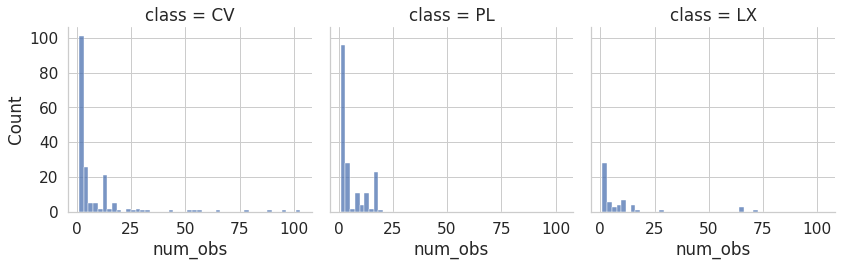

In [22]:
sns.set(font_scale=1.4)
sns.set_style('whitegrid')
sns.displot(
    data = df_comb , 
    x = 'num_obs' , 
    kind = 'hist' ,
    col = 'class' , 
    height= 4 ,
    aspect= 4/4
)
plt.show()